In [1]:
import os
import sys
import os.path as osp
os.chdir('../')
sys.path.append(os.path.abspath('./detection'))
sys.path.append(os.path.abspath('./tracking'))
import yaml
import numpy as np
import torch
from torch.utils.data import DataLoader
import mmengine
from matplotlib import pyplot as plt
from mmengine.config import Config
from mmdet3d.registry import MODELS, TRANSFORMS
from mmdet3d.utils import register_all_modules
from mmengine.runner import load_checkpoint
from mmdet3d.structures import LiDARInstance3DBoxes
from mmdet3d.structures import Box3DMode
from mot_3d.mot import MOTModel
from mot_3d.data_protos import BBox
from mot_3d.frame_data import FrameData
from trajectory_prediction.tools.dataset import TrajectoryDataset
from trajectory_prediction.model.model import TrajectoryModel

In [2]:
def data_preprocess(tracks, config):
    
    obs_len = config['obs_len']
    nei_radius = config['nei_radius']
    obs = []
    neis_ = []
    num_neis = []
    self_labels = []
    nei_labels_ = []
    refs = []
    rot_mats = []
    all_label_ids = list(tracks.keys())
    all_labels = np.array([int(label_id.split('_')[0]) for label_id in all_label_ids])
    all_tracks = np.array([tracks[k]['data'] for k in all_label_ids])

    for i in range(len(all_tracks)):
        if all_tracks[i][-1][0] > 1e8 or all_tracks[i][obs_len-2][0] > 1e8 or all_labels[i] == 3:
            continue
        ob = all_tracks[i].copy()
        for j in range(obs_len - 2, -1, -1):
            if ob[j][0] > 1e8:
                ob[j] = ob[j+1]
        nei = all_tracks[np.arange(len(all_tracks)) != i]
        nei_labels = all_labels[np.arange(len(all_labels)) != i]
        now_nei_radius = [nei_radius[label] for label in nei_labels]
        dist_threshold = np.maximum(nei_radius[all_labels[i]], now_nei_radius)
        dist = np.linalg.norm(ob[:obs_len].reshape(1, obs_len, 2) - nei, axis=-1)
        dist = np.min(dist, axis=-1)
        nei = nei[dist < dist_threshold]
        nei_labels = nei_labels[dist < dist_threshold]
        
        ref = ob[-1]
        ob = ob - ref
        if nei.shape[0] != 0:
            nei = nei - ref
        angle = np.arctan2(ob[0][1], ob[0][0])
        rot_mat = np.array([[np.cos(angle), -np.sin(angle)], 
                            [np.sin(angle), np.cos(angle)]])
        ob = np.dot(ob, rot_mat)
        if nei.shape[0] != 0:
            nei = np.dot(nei, rot_mat)
        
        obs.append(ob)
        neis_.append(nei)
        num_neis.append(nei.shape[0])
        self_labels.append(all_labels[i])
        nei_labels_.append(nei_labels)
        refs.append(ref.flatten())
        rot_mats.append(rot_mat)
        
    if len(obs) == 0:
        return None
            
    max_num_nei = max(num_neis)
    if max_num_nei == 0:
        max_num_nei = 1
    nei_masks = torch.zeros(len(obs), max_num_nei, dtype=torch.bool)
    neis = torch.zeros(len(obs), max_num_nei, obs_len, 2)
    nei_labels = torch.zeros(len(obs), max_num_nei, dtype=torch.int32) - 1
    for i in range(len(obs)):
        nei_masks[i, :num_neis[i]] = True
        neis[i, :num_neis[i]] = torch.tensor(neis_[i])
        nei_labels[i, :num_neis[i]] = torch.tensor(nei_labels_[i])
    
    obs = torch.tensor(np.stack(obs, axis=0), dtype=torch.float32)
    self_labels = torch.tensor(self_labels, dtype=torch.int32)
    refs = torch.tensor(np.stack(refs, axis=0), dtype=torch.float32)
    rot_mats = torch.tensor(np.stack(rot_mats, axis=0), dtype=torch.float32)
    return obs, neis, nei_masks, self_labels, nei_labels, refs, rot_mats


def update_tracks(tracks, labels, ids, xys, config):

    obs_len = config['obs_len']
    is_updated = {k: False for k in tracks.keys()}
    for i in range(len(labels)):
        label_id = str(labels[i]) + '_' + str(ids[i])
        if tracks.get(label_id) is None:
            tracks[label_id] = {
                'data': [[1e9, 1e9] for _ in range(obs_len - 1)] + [xys[i].tolist()],
                'label': labels[i], 
                'lost_frame': 0}
        else:
            tracks[label_id]['data'].pop(0)
            tracks[label_id]['data'].append(xys[i].tolist())
            tracks[label_id]['lost_frame'] = 0
            is_updated[label_id] = True

    for k in is_updated.keys():
        if not is_updated[k]:
            if tracks[k]['lost_frame'] < obs_len:
                tracks[k]['data'].pop(0)
                tracks[k]['data'].append([1e9, 1e9])
                tracks[k]['lost_frame'] += 1
            else:
                del tracks[k]
    return tracks

In [3]:
# load detection model
cfg = Config.fromfile('./detection/my_projects/CMDT/configs/cmdt_coda.py')
checkpoint = './detection/ckpts/CMDT/cmdt_coda.pth'
info_path = './detection/data/CODA/coda_infos_val_full.pkl'
register_all_modules()
detect_model = MODELS.build(cfg.model)
pipeline = []
for transform in cfg.test_dataloader.dataset.pipeline:
    pipeline.append(TRANSFORMS.build(transform))
checkpoint = load_checkpoint(detect_model, checkpoint, map_location='cpu')
detect_model.cuda().eval()

# load tracking model
config_path = './tracking/configs/coda_configs/diou.yaml'
track_config = yaml.load(open(config_path, 'r'), Loader=yaml.Loader)
class_labels = [0, 1, 2]
class_names = ['car', 'pedestrian', 'cyclist']
trackers = [MOTModel(track_config, class_names[label]) for label in class_labels]

# load trajectory prediction model
config_path = './trajectory_prediction/configs/coda.yaml'
checkpoint = './trajectory_prediction/checkpoints/coda_best.pth'
traj_pred_config = yaml.load(open(config_path, 'r'), Loader=yaml.FullLoader)
traj_pred_model = TrajectoryModel(num_class=traj_pred_config['num_class'], in_size=2, 
                obs_len=traj_pred_config['obs_len'], pred_len=traj_pred_config['pred_len'], 
                embed_size=traj_pred_config['embed_size'], num_decode_layers=traj_pred_config['num_decode_layers'], 
                scale=traj_pred_config['scale'], pred_single=False)
traj_pred_model.load_state_dict(torch.load(checkpoint))
traj_pred_model.cuda().eval()

# load data_info
data_info = mmengine.load(info_path)
tracks = {}
count = 2550

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loads checkpoint by local backend from path: ./detection/ckpts/CMDT/cmdt_coda.pth


In [14]:
for i in range(1):
    
    #  load data
    input = data_info['data_list'][count]
    token = input['token']
    timestamp = input['timestamp']
    ego2global = input['ego2global']
    path_prefix = info_path[:info_path.rfind('/')+1]
    input['lidar_points']['lidar_path'] = path_prefix + input['lidar_points']['lidar_path']
    for image in input['images'].values():
        image['img_path'] = path_prefix + image['img_path']
    input['box_type_3d'] = LiDARInstance3DBoxes
    input['box_mode_3d'] = Box3DMode.LIDAR

    # detection
    with torch.no_grad():
        for transform in pipeline:
            input = transform(input)
        input['data_samples'] = [input['data_samples']]
        input['inputs']['points'] = [input['inputs']['points']]
        input['inputs']['img'] = [input['inputs']['img']]
        output = detect_model.data_preprocessor(input, training=False)
        output = detect_model(**output, mode='predict')
        bboxes_3d = output[0].get('pred_instances_3d')['bboxes_3d']
        labels_3d = output[0].get('pred_instances_3d')['labels_3d']
        scores_3d = output[0].get('pred_instances_3d')['scores_3d']
        bboxes_3d = bboxes_3d[scores_3d > 0.3].tensor.cpu().numpy()
        labels_3d = labels_3d[scores_3d > 0.3].cpu().numpy()
        scores_3d = scores_3d[scores_3d > 0.3].cpu().numpy()

    # tracking
    track_labels = []
    track_ids = []
    track_bboxes = []
    track_states = []
    for i, label in enumerate(class_labels):
        mask = labels_3d == label
        dets = np.concatenate([bboxes_3d[mask], scores_3d[mask][:, None]], axis=1).tolist()
        frame_data = FrameData(dets=dets, ego=ego2global, pc=None, det_types=labels_3d[mask], time_stamp=float(timestamp))
        frame_data.dets = [BBox.bbox2world(ego2global, det) for det in frame_data.dets]
        results = trackers[i].frame_mot(frame_data)
        track_labels.append([trk[3] for trk in results])
        track_ids.append([trk[1] for trk in results])
        track_bboxes.append(np.array([BBox.bbox2array(trk[0]) for trk in results]))
        track_states.append([trk[2] for trk in results])

    # trajectory prediction
    topK = 5
    update_labels = []
    update_ids = []
    update_xys = []
    updata_bboxes = []
    for i, label in enumerate(class_labels):
        for j in range(len(track_bboxes[i])):
            state = track_states[i][j].split('_')
            if state[0] == 'birth' or (state[0] == 'alive' and int(state[1]) == 1):
                update_labels.append(label)
                update_ids.append(track_ids[i][j])
                update_xys.append(track_bboxes[i][j][:2])
                updata_bboxes.append(track_bboxes[i][j])
    update_labels.append(3)
    update_ids.append(0)
    update_xys.append(ego2global[:2, 3])
    update_tracks(tracks, update_labels, update_ids, update_xys, traj_pred_config)
    data_input = data_preprocess(tracks, traj_pred_config)
    if data_input is not None:
        with torch.no_grad():
            data_input = [tensor.cuda() for tensor in data_input]
            obs, neis, nei_masks, self_labels, nei_labels, refs, rot_mats = data_input
            preds, scores, _ = traj_pred_model(obs, neis, nei_masks, self_labels, nei_labels)
            scores = torch.nn.functional.softmax(scores, dim=-1)
            topK_scores, topK_indices = torch.topk(scores, topK, dim=-1) # [B topK], [B topK]
            topK_preds = torch.gather(preds, 1, topK_indices.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, preds.size(-2), preds.size(-1))) # [B topK pred_len in_size]
            rot_mats_T = rot_mats.transpose(1, 2)
            obs_ori = torch.matmul(obs, rot_mats_T) + refs.unsqueeze(1)
            preds_ori = torch.matmul(topK_preds, rot_mats_T.unsqueeze(1)) + refs.unsqueeze(1).unsqueeze(2)
            obs_ori = obs_ori.cpu().numpy()
            preds_ori = preds_ori.cpu().numpy()

    count += 1
print(count)

2601


(-79.489653, -39.489653, 166.568031, 206.568031)

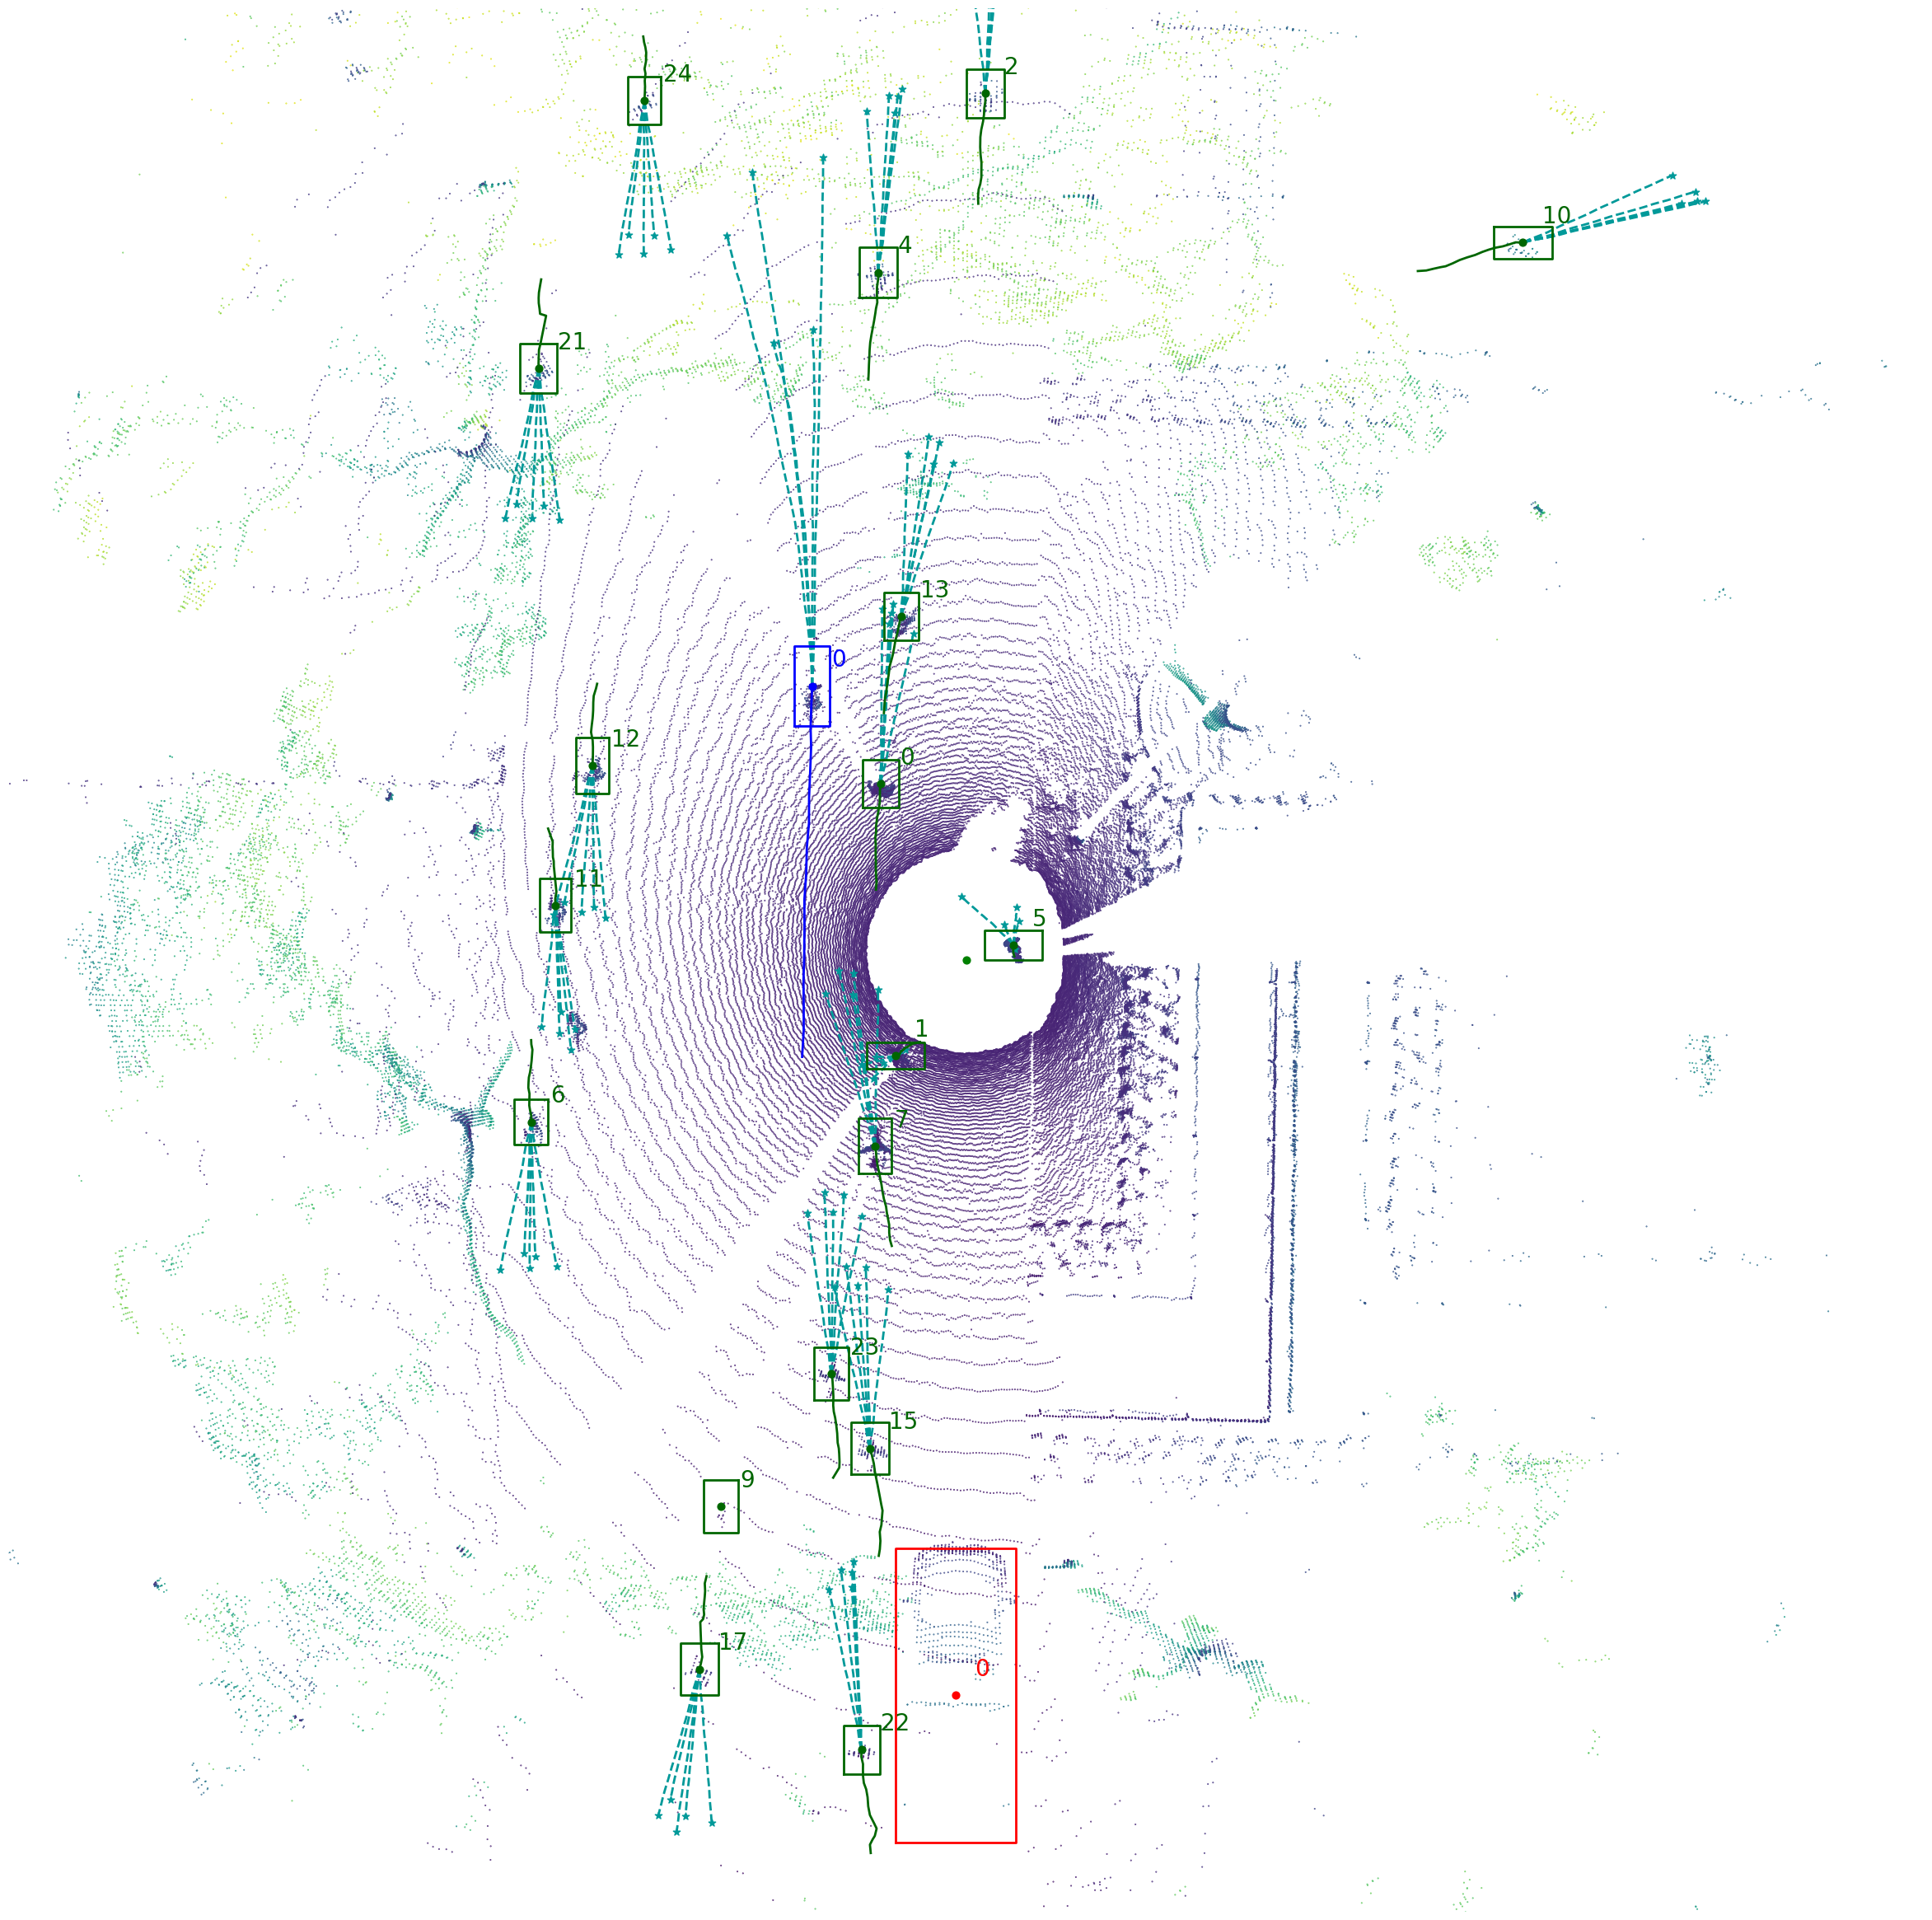

In [19]:
# visualization
pcd_range = [-20.0, 20.0, -20.0, 20.0, -0.5, 6.0]
self_pos = ego2global[:3, 3]
self_yaw = np.arctan2(ego2global[1, 0], ego2global[0, 0])
plot_range = pcd_range.copy()
plot_range[0] += self_pos[0]
plot_range[1] += self_pos[0]
plot_range[2] += self_pos[1]
plot_range[3] += self_pos[1]
plot_range[4] += self_pos[2]
plot_range[5] += self_pos[2]
plt.figure(figsize=(30, 30))
plt.xlim(plot_range[0], plot_range[1])
plt.ylim(plot_range[2], plot_range[3])
label_colors = [[1, 0, 0], [0, 0.4, 0], [0, 0, 1]]
traj_pred_color = [0, 0.6, 0.6]
size = 0.2
points = input['inputs']['points'][0][:, :3].cpu().numpy()
points = np.concatenate([points, np.ones((points.shape[0], 1))], axis=1)
points = np.dot(ego2global, points.T).T[:, :3]
plt.scatter(points[:, 0], points[:, 1], c=points[:, 2], cmap='viridis', s=size)
plt.scatter(self_pos[0], self_pos[1], c='g', s=200*size, zorder=3)
# plt.arrow(self_pos[0], self_pos[1], np.cos(self_yaw), np.sin(self_yaw), color='r', width=size, zorder=2)

for i in range(len(update_labels)):
    if update_labels[i] == 3:
        continue
    color = label_colors[update_labels[i]]
    # 绘制bev视角下的检测框
    bbox = updata_bboxes[i]
    # x1, y1, x2, y2 = bbox[0]-bbox[3]/2, bbox[1]-bbox[4]/2, bbox[0]+bbox[3]/2, bbox[1]+bbox[4]/2
    # 考虑到yaw角度
    yaw = bbox[6]
    if yaw < 0:
        yaw += 2 * np.pi
    x1 = bbox[0] - bbox[3] / 2 * np.cos(yaw) - bbox[4] / 2 * np.sin(yaw)
    y1 = bbox[1] - bbox[3] / 2 * np.sin(yaw) + bbox[4] / 2 * np.cos(yaw)
    x2 = bbox[0] + bbox[3] / 2 * np.cos(yaw) + bbox[4] / 2 * np.sin(yaw)
    y2 = bbox[1] + bbox[3] / 2 * np.sin(yaw) - bbox[4] / 2 * np.cos(yaw)
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color=color, linestyle='-', linewidth=10*size, zorder=2)
    plt.scatter(bbox[0], bbox[1], color=color, s=200*size, zorder=3)
    plt.text(bbox[0]+0.4, bbox[1]+0.4, str(int(update_ids[i])), fontsize=100*size, color=color, zorder=4)

for i in range(obs_ori.shape[0]):
    # plt.text(obs[i, -1, 0], obs[i, -1, 1], ids[i], fontsize=6*size, color='black', zorder=4)
    # plt.plot(obs_ori[i, :, 0], obs_ori[i, :, 1], c='r', linestyle='-', linewidth=10*size, zorder=2)
    plt.plot(obs_ori[i, :, 0], obs_ori[i, :, 1], color=label_colors[self_labels[i]], linestyle='-', linewidth=10*size, zorder=2)
    for j in range(preds_ori.shape[1]):
        pred = np.concatenate([obs_ori[i, -1].reshape(1, 2), preds_ori[i, j]], axis=0)
        plt.plot(pred[:, 0], pred[:, 1], color=traj_pred_color, linestyle='--', linewidth=10*size, zorder=1)
        plt.scatter(pred[-1, 0], pred[-1, 1], color=traj_pred_color, marker='*', s=200*size, zorder=1)
# 绘制自车轨迹
self_track = np.array(tracks['3_0']['data'])
for i in range(len(self_track)-1):
    if self_track[i][0] > 1e8 or self_track[i+1][0] > 1e8:
        continue
    plt.plot([self_track[i][0], self_track[i+1][0]], [self_track[i][1], self_track[i+1][1]], c='g', linestyle='-', linewidth=15*size, zorder=2)
plt.axis('off')